In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 161
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  STI6WR1Z_12_43_47
NN-MODEL FILENAME:  ./models/STI6WR1Z_12_43_47_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 10
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  10


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
#     LENGTH_MAX = length_mean + 0.05
#     LENGTH_MIN = length_mean - 0.05
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
    my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     my_Q_TABLE = np.load(my_QFILE)
    my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

    LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.075, LENGTH_ABS_MAX)
    LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.075, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
my_dqn = D3QN()
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

#  # SET STATE VALUE BORDERS
# ###############################################
# [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#  C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
# ###############################################

# # CREATE STATE COMBINATIONS
# ###############################################

# init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
#                                     [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
#                                     [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
# ###############################################

# # GET Q-VALUES 
# start = timeit.default_timer()
# % memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
# stop = timeit.default_timer()
# print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# # SAVE QFILE
# for node_id in range(NO_OF_NODES):
#     node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     np.save(node_QFILE, init_q_table)
# #############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.1
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 22854 EXPERIENCES:0:00:19.160762


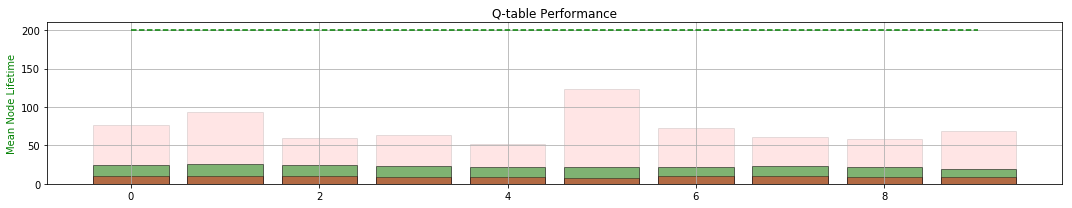

GOOD MEMORY COUNTER:  21854
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  156.15
Validating... MEAN TIME:  149.78
Validating... MEAN TIME:  159.71
Validating... MEAN TIME:  151.265
Validating... MEAN TIME:  143.365
TRAINING TIME:0:00:41.270719


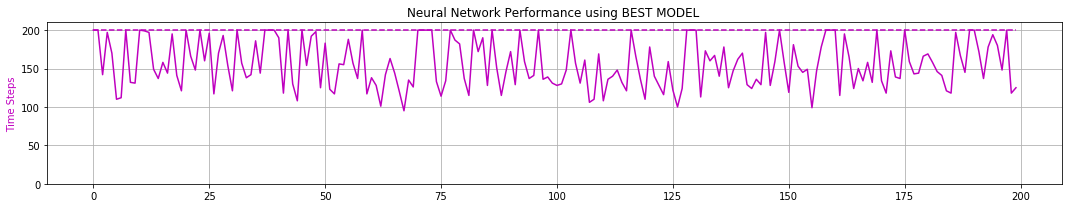

0 -max- [ 0.930  2.050  0.209  2.244  0.550]
0 -min- [-0.404 -1.376 -0.209 -2.897  0.375]

1 -max- [ 0.518  1.912  0.209  2.782  0.599]
1 -min- [-0.405 -1.718 -0.209 -2.578  0.400]

2 -max- [ 0.414  2.092  0.206  2.452  0.650]
2 -min- [-0.488 -1.612 -0.209 -2.736  0.450]

3 -max- [ 0.598  1.868  0.209  2.023  0.699]
3 -min- [-0.431 -1.932 -0.209 -2.429  0.500]

4 -max- [ 0.458  1.667  0.209  2.708  0.750]
4 -min- [-0.184 -1.741 -0.208 -2.359  0.551]

5 -max- [ 2.043  2.484  0.208  2.503  0.800]
5 -min- [-0.693 -1.928 -0.209 -2.492  0.600]

6 -max- [ 0.726  1.899  0.207  2.132  0.849]
6 -min- [-0.508 -1.713 -0.209 -2.683  0.650]

7 -max- [ 0.400  1.516  0.208  1.911  0.900]
7 -min- [-0.285 -1.332 -0.209 -2.371  0.701]

8 -max- [ 0.335  2.105  0.204  1.984  0.925]
8 -min- [-0.167 -1.318 -0.209 -2.518  0.750]

9 -max- [ 0.280  2.168  0.208  2.657  0.925]
9 -min- [-0.312 -1.948 -0.209 -2.838  0.801]



ITERATION # 1
MEAN TABULAR EPSILON =  0.4
TABULAR LR      =  0.1
SMALLEST TIMESTEP in IT

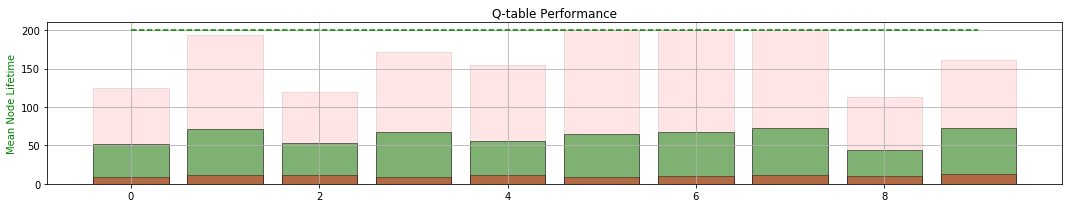

GOOD MEMORY COUNTER:  82850
BAD MEMORY COUNTER:  1997
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  142.025
Validating... MEAN TIME:  157.92
Validating... MEAN TIME:  154.525
Validating... MEAN TIME:  147.39
Validating... MEAN TIME:  137.48
TRAINING TIME:0:00:38.796395


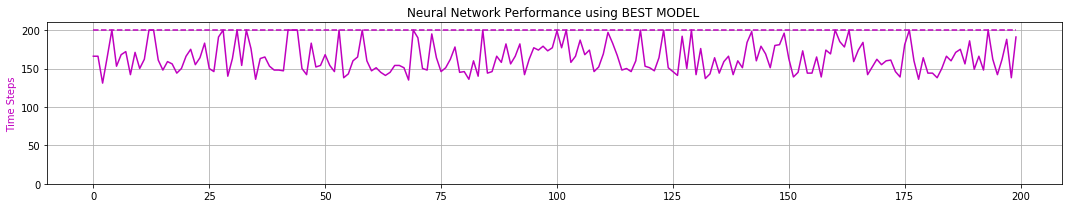

0 -max- [ 0.735  1.734  0.209  2.220  0.549]
0 -min- [-1.158 -2.413 -0.209 -2.148  0.375]

1 -max- [ 0.970  1.864  0.209  2.489  0.600]
1 -min- [-1.641 -2.446 -0.208 -2.572  0.400]

2 -max- [ 0.557  1.931  0.208  2.105  0.650]
2 -min- [-1.103 -1.859 -0.209 -2.305  0.451]

3 -max- [ 1.066  2.636  0.209  2.057  0.700]
3 -min- [-1.451 -2.570 -0.209 -2.149  0.500]

4 -max- [ 0.876  2.067  0.208  2.379  0.750]
4 -min- [-1.755 -2.278 -0.209 -2.294  0.550]

5 -max- [ 0.698  2.083  0.209  2.197  0.799]
5 -min- [-1.233 -2.130 -0.209 -2.153  0.600]

6 -max- [ 0.772  1.928  0.209  1.991  0.850]
6 -min- [-1.542 -2.354 -0.209 -2.775  0.650]

7 -max- [ 0.863  1.664  0.208  2.699  0.899]
7 -min- [-1.203 -2.598 -0.209 -2.076  0.700]

8 -max- [ 1.001  2.132  0.209  2.510  0.925]
8 -min- [-1.043 -2.260 -0.209 -2.450  0.750]

9 -max- [ 0.839  2.061  0.209  2.308  0.925]
9 -min- [-1.223 -2.072 -0.209 -2.430  0.801]



ITERATION # 2
MEAN TABULAR EPSILON =  0.6000000000000001
TABULAR LR      =  0.1
SMALLEST

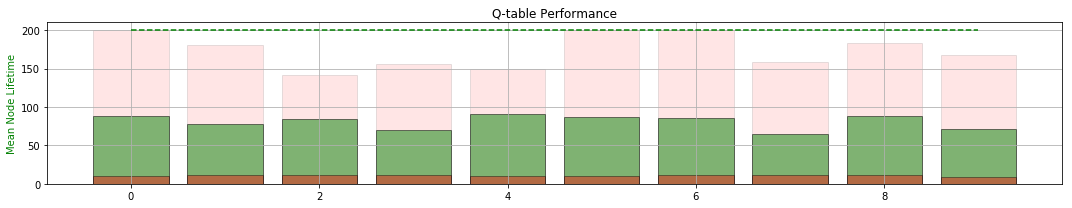

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2994
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  128.46
Validating... MEAN TIME:  162.39
Validating... MEAN TIME:  135.51
Validating... MEAN TIME:  190.565
Validating... MEAN TIME:  143.39
TRAINING TIME:0:00:39.785065


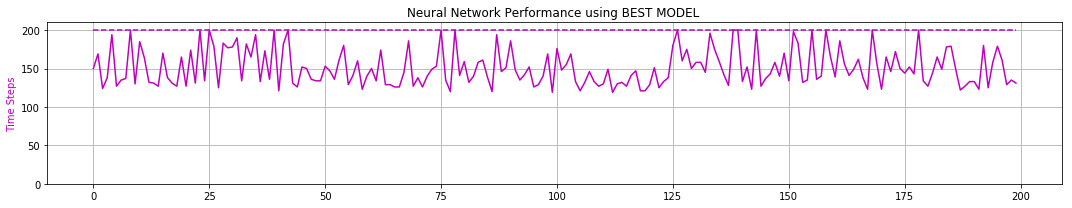

0 -max- [ 0.353  1.526  0.208  1.576  0.549]
0 -min- [-2.396 -3.086 -0.209 -2.432  0.375]

1 -max- [ 0.313  1.550  0.200  1.485  0.598]
1 -min- [-2.363 -2.777 -0.209 -2.066  0.400]

2 -max- [ 0.145  0.951  0.205  1.521  0.650]
2 -min- [-2.393 -2.920 -0.209 -2.180  0.450]

3 -max- [ 0.192  1.201  0.208  1.523  0.699]
3 -min- [-2.392 -3.285 -0.209 -2.218  0.500]

4 -max- [ 0.196  1.013  0.133  1.414  0.750]
4 -min- [-2.400 -2.978 -0.209 -1.788  0.550]

5 -max- [ 2.297  2.399  0.200  2.000  0.798]
5 -min- [-2.387 -2.897 -0.209 -1.892  0.600]

6 -max- [ 0.272  1.344  0.204  1.531  0.850]
6 -min- [-2.369 -2.595 -0.209 -2.520  0.650]

7 -max- [ 1.493  1.666  0.204  2.126  0.899]
7 -min- [-2.010 -2.572 -0.209 -2.400  0.700]

8 -max- [ 0.147  1.184  0.203  2.102  0.925]
8 -min- [-2.359 -2.912 -0.209 -2.002  0.750]

9 -max- [ 0.257  1.565  0.208  2.127  0.925]
9 -min- [-2.394 -3.092 -0.209 -2.313  0.800]



ITERATION # 3
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

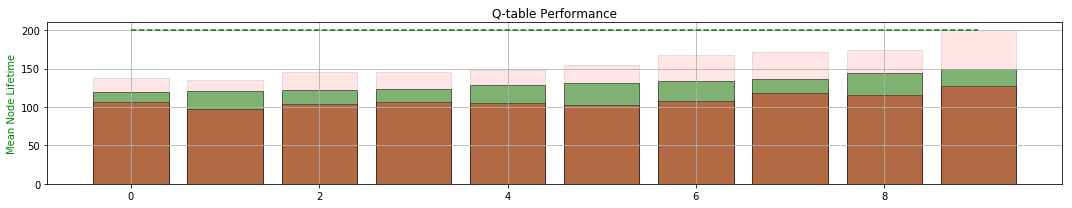

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3990
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  126.575
Validating... MEAN TIME:  142.355
Validating... MEAN TIME:  134.32
Validating... MEAN TIME:  177.115
Validating... MEAN TIME:  139.605
TRAINING TIME:0:00:36.861433


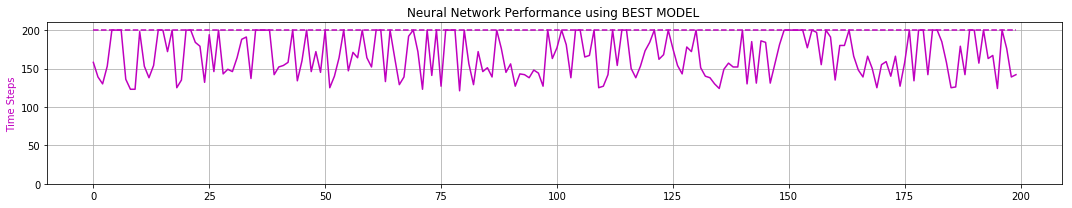

0 -max- [ 0.152  0.817  0.050  0.849  0.550]
0 -min- [-2.400 -2.963 -0.209 -1.080  0.375]

1 -max- [ 0.132  0.813  0.048  0.727  0.599]
1 -min- [-2.400 -2.965 -0.209 -1.159  0.400]

2 -max- [ 0.116  0.816  0.049  0.790  0.650]
2 -min- [-2.400 -2.975 -0.209 -1.120  0.450]

3 -max- [ 0.130  0.633  0.050  0.915  0.699]
3 -min- [-2.400 -2.970 -0.209 -0.961  0.500]

4 -max- [ 0.138  0.627  0.050  0.988  0.749]
4 -min- [-2.399 -2.908 -0.209 -0.900  0.550]

5 -max- [ 0.125  0.629  0.049  0.904  0.799]
5 -min- [-2.394 -2.885 -0.209 -0.973  0.600]

6 -max- [ 0.122  0.825  0.049  0.991  0.848]
6 -min- [-2.398 -2.890 -0.209 -1.128  0.650]

7 -max- [ 0.119  0.625  0.048  0.727  0.900]
7 -min- [-2.330 -2.711 -0.209 -0.897  0.701]

8 -max- [ 0.106  0.631  0.050  1.021  0.925]
8 -min- [-2.297 -2.587 -0.209 -0.930  0.750]

9 -max- [ 0.127  0.628  0.049  0.886  0.925]
9 -min- [-2.176 -2.421 -0.209 -0.997  0.801]



ITERATION # 4
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

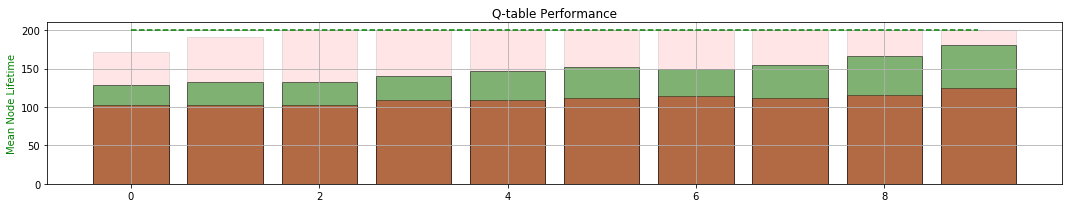

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4840
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  139.39
Validating... MEAN TIME:  169.48
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.42
Validating... MEAN TIME:  136.845
TRAINING TIME:0:00:41.525807


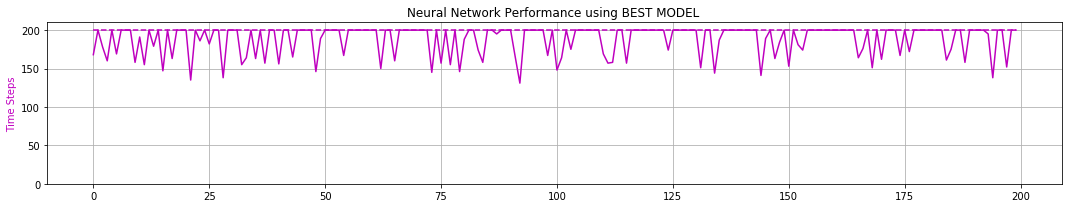

0 -max- [ 0.125  0.428  0.048  0.863  0.549]
0 -min- [-2.368 -2.926 -0.209 -0.935  0.375]

1 -max- [ 0.139  0.437  0.049  0.766  0.600]
1 -min- [-2.387 -2.888 -0.209 -0.976  0.401]

2 -max- [ 0.149  0.437  0.050  0.806  0.650]
2 -min- [-2.174 -2.746 -0.209 -0.829  0.450]

3 -max- [ 0.149  0.428  0.050  0.897  0.700]
3 -min- [-2.234 -2.746 -0.209 -1.022  0.501]

4 -max- [ 0.250  0.603  0.049  0.718  0.749]
4 -min- [-2.068 -2.612 -0.209 -1.019  0.553]

5 -max- [ 0.493  0.631  0.049  0.850  0.800]
5 -min- [-2.055 -2.605 -0.209 -0.859  0.600]

6 -max- [ 0.537  0.433  0.048  0.721  0.850]
6 -min- [-1.881 -2.382 -0.209 -0.782  0.650]

7 -max- [ 1.004  0.760  0.050  0.915  0.900]
7 -min- [-1.848 -2.401 -0.209 -0.839  0.701]

8 -max- [ 1.465  0.964  0.050  0.877  0.925]
8 -min- [-1.887 -2.408 -0.209 -0.799  0.750]

9 -max- [ 1.579  0.972  0.049  0.918  0.925]
9 -min- [-1.786 -2.217 -0.209 -0.824  0.800]



ITERATION # 5
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

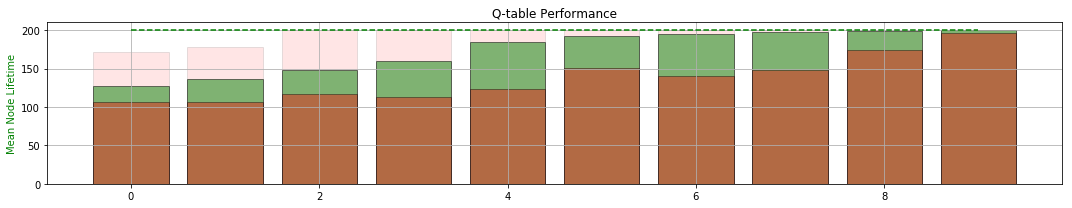

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5353
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  197.245
Validating... MEAN TIME:  186.54
Validating... MEAN TIME:  185.56
Validating... MEAN TIME:  160.985
Validating... MEAN TIME:  170.48
TRAINING TIME:0:00:44.081752


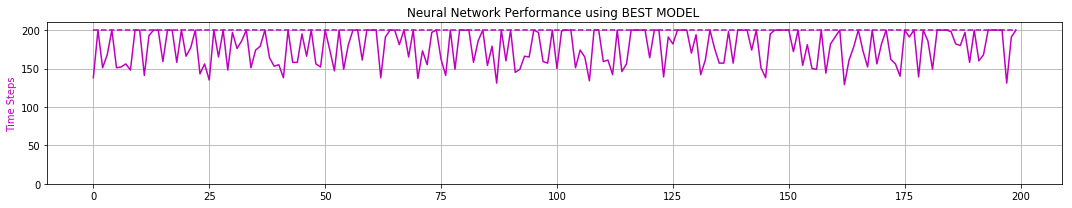

0 -max- [ 0.119  0.437  0.049  0.664  0.550]
0 -min- [-1.919 -2.514 -0.209 -0.825  0.375]

1 -max- [ 0.127  0.438  0.050  0.700  0.599]
1 -min- [-1.839 -2.429 -0.209 -0.805  0.400]

2 -max- [ 0.143  0.575  0.050  0.674  0.650]
2 -min- [-1.925 -2.398 -0.209 -0.807  0.450]

3 -max- [ 0.206  0.584  0.054  0.624  0.698]
3 -min- [-1.896 -2.415 -0.209 -0.770  0.500]

4 -max- [ 0.480  0.573  0.049  0.752  0.750]
4 -min- [-1.800 -2.344 -0.209 -0.960  0.551]

5 -max- [ 0.619  0.700  0.055  0.707  0.800]
5 -min- [-1.613 -2.159 -0.209 -0.838  0.600]

6 -max- [ 1.114  0.802  0.062  0.949  0.850]
6 -min- [-1.698 -2.066 -0.209 -0.948  0.651]

7 -max- [ 1.598  1.143  0.085  0.981  0.900]
7 -min- [-1.487 -1.870 -0.209 -0.821  0.700]

8 -max- [ 1.609  1.176  0.061  0.906  0.925]
8 -min- [-1.387 -1.681 -0.208 -0.930  0.750]

9 -max- [ 2.391  1.721  0.079  0.749  0.925]
9 -min- [-1.332 -1.273 -0.168 -1.029  0.801]



ITERATION # 6
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

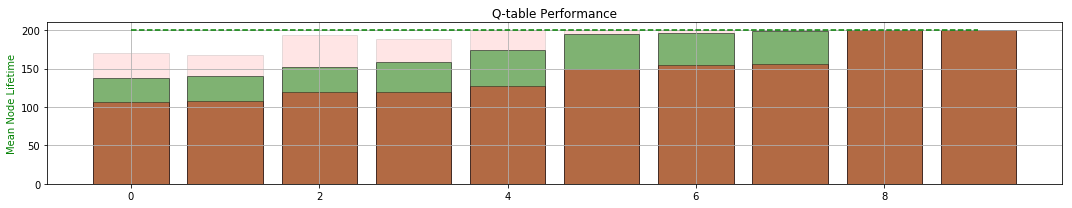

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5895
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  190.385
Validating... MEAN TIME:  144.45
Validating... MEAN TIME:  162.76
Validating... MEAN TIME:  183.43
Validating... MEAN TIME:  161.35
TRAINING TIME:0:00:42.629758


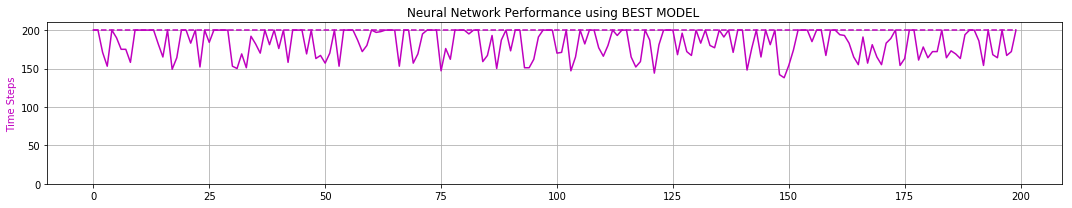

0 -max- [ 0.123  0.597  0.050  0.577  0.550]
0 -min- [-2.399 -2.961 -0.209 -0.877  0.375]

1 -max- [ 0.111  0.577  0.050  0.682  0.600]
1 -min- [-2.397 -2.974 -0.209 -0.851  0.400]

2 -max- [ 0.134  0.578  0.049  0.680  0.650]
2 -min- [-2.399 -2.964 -0.209 -0.898  0.450]

3 -max- [ 0.116  0.577  0.049  0.703  0.700]
3 -min- [-2.396 -2.957 -0.209 -0.872  0.500]

4 -max- [ 0.130  0.751  0.048  0.621  0.749]
4 -min- [-2.400 -3.081 -0.209 -1.102  0.550]

5 -max- [ 0.208  0.590  0.050  0.718  0.800]
5 -min- [-2.398 -2.887 -0.209 -0.868  0.600]

6 -max- [ 0.422  0.601  0.056  0.986  0.849]
6 -min- [-2.399 -2.792 -0.209 -0.865  0.650]

7 -max- [ 0.753  0.784  0.061  0.730  0.898]
7 -min- [-2.380 -2.699 -0.209 -0.874  0.701]

8 -max- [ 1.153  1.119  0.062  0.984  0.925]
8 -min- [-0.983 -1.313 -0.164 -1.035  0.750]

9 -max- [ 1.427  1.303  0.079  1.180  0.925]
9 -min- [-1.297 -1.699 -0.186 -1.198  0.801]



ITERATION # 7
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

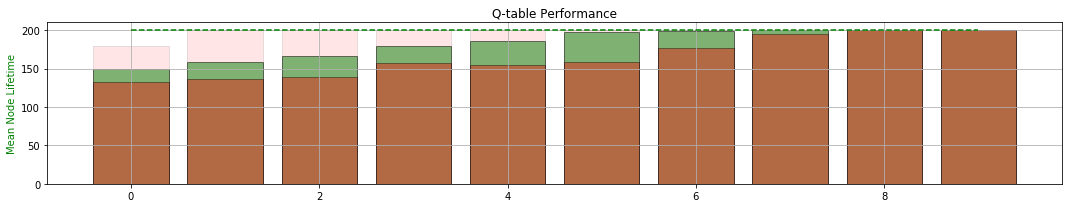

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6381
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  191.91
Validating... MEAN TIME:  173.435
Validating... MEAN TIME:  174.27
Validating... MEAN TIME:  196.665
Validating... MEAN TIME:  191.015
TRAINING TIME:0:00:46.518876


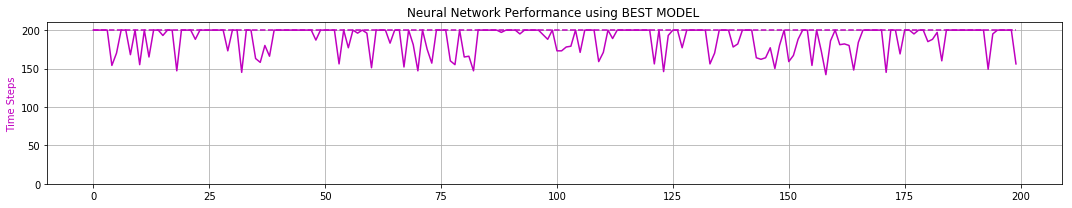

0 -max- [ 0.123  0.598  0.050  1.306  0.549]
0 -min- [-2.400 -3.177 -0.195 -1.043  0.375]

1 -max- [ 0.157  0.435  0.049  1.323  0.600]
1 -min- [-2.400 -3.159 -0.207 -1.066  0.400]

2 -max- [ 0.134  0.437  0.049  1.084  0.648]
2 -min- [-2.399 -2.970 -0.207 -1.086  0.450]

3 -max- [ 0.129  0.439  0.048  1.167  0.699]
3 -min- [-2.400 -2.921 -0.196 -0.919  0.500]

4 -max- [ 0.321  0.722  0.050  1.018  0.750]
4 -min- [-2.399 -2.804 -0.208 -1.079  0.551]

5 -max- [ 0.415  0.718  0.056  1.002  0.800]
5 -min- [-2.399 -2.811 -0.185 -0.992  0.600]

6 -max- [ 0.485  1.075  0.071  1.013  0.849]
6 -min- [-2.398 -2.731 -0.172 -0.923  0.650]

7 -max- [ 0.905  1.096  0.075  1.030  0.900]
7 -min- [-2.364 -2.608 -0.151 -1.190  0.701]

8 -max- [ 1.359  1.647  0.123  1.149  0.925]
8 -min- [-0.907 -1.008 -0.116 -1.264  0.751]

9 -max- [ 1.148  1.180  0.085  1.384  0.925]
9 -min- [-0.440 -1.144 -0.117 -1.346  0.800]



ITERATION # 8
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

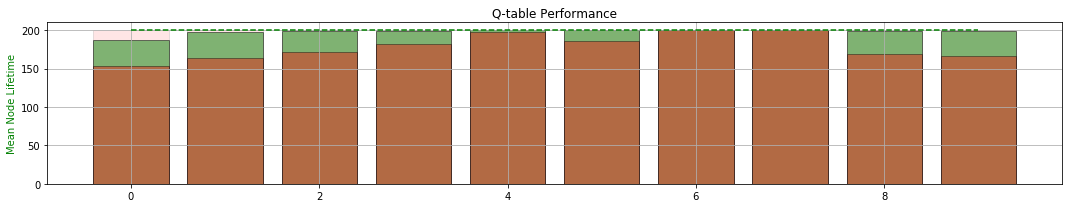

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6485
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  168.6
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  195.075
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:48.435448


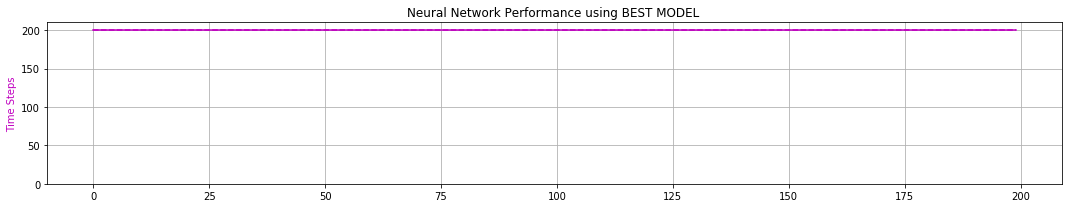

0 -max- [ 0.477  1.072  0.209  1.492  0.550]
0 -min- [-2.399 -2.549 -0.184 -1.304  0.375]

1 -max- [ 1.121  1.803  0.209  1.500  0.597]
1 -min- [-2.396 -2.406 -0.176 -1.061  0.400]

2 -max- [ 1.299  1.790  0.209  1.236  0.649]
2 -min- [-2.255 -2.161 -0.146 -1.052  0.450]

3 -max- [ 1.413  1.507  0.209  1.389  0.700]
3 -min- [-1.679 -1.332 -0.113 -1.054  0.500]

4 -max- [ 2.356  3.279  0.208  1.396  0.750]
4 -min- [-0.923 -1.292 -0.135 -1.348  0.550]

5 -max- [ 1.641  1.822  0.206  1.908  0.800]
5 -min- [-0.617 -1.694 -0.202 -1.403  0.600]

6 -max- [ 2.088  1.523  0.101  2.075  0.850]
6 -min- [-0.410 -1.525 -0.167 -1.475  0.650]

7 -max- [ 2.086  1.313  0.105  1.656  0.900]
7 -min- [-0.251 -1.125 -0.115 -1.307  0.701]

8 -max- [ 2.393  1.745  0.128  1.932  0.925]
8 -min- [-0.143 -1.201 -0.150 -1.839  0.751]

9 -max- [ 2.396  1.933  0.146  1.911  0.925]
9 -min- [-0.151 -1.160 -0.194 -1.968  0.801]



ITERATION # 9
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

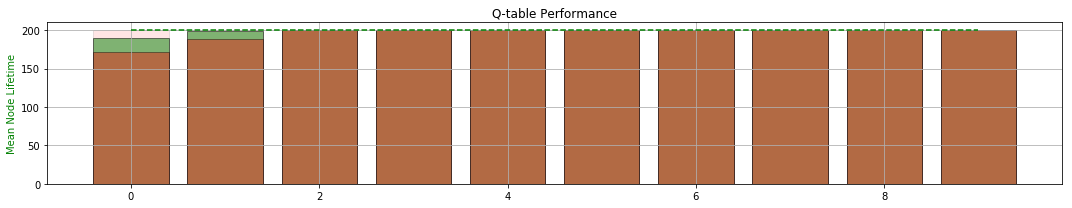

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6576
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  195.51
Validating... MEAN TIME:  199.555
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:47.964210


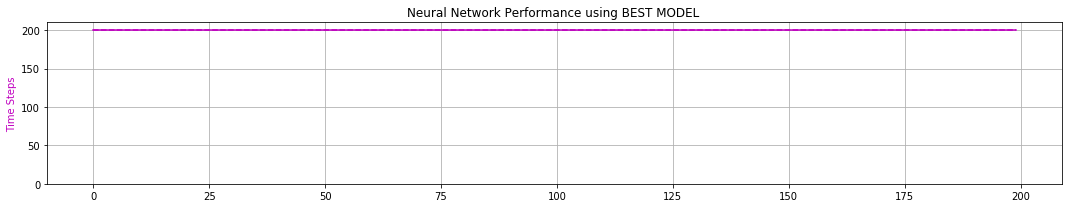

0 -max- [ 0.127  0.631  0.049  1.000  0.550]
0 -min- [-2.398 -2.229 -0.208 -1.324  0.375]

1 -max- [ 0.132  0.625  0.048  1.009  0.598]
1 -min- [-2.397 -2.061 -0.209 -1.288  0.400]

2 -max- [ 0.106  0.629  0.050  0.997  0.649]
2 -min- [-2.289 -1.715 -0.167 -1.051  0.451]

3 -max- [ 0.256  0.626  0.052  1.099  0.700]
3 -min- [-1.571 -1.543 -0.127 -1.071  0.500]

4 -max- [ 0.134  0.438  0.048  1.184  0.750]
4 -min- [-1.263 -1.347 -0.103 -1.067  0.550]

5 -max- [ 0.145  0.445  0.054  1.204  0.800]
5 -min- [-0.821 -0.968 -0.058 -0.739  0.600]

6 -max- [ 0.194  0.619  0.066  1.428  0.850]
6 -min- [-0.571 -1.154 -0.094 -1.017  0.651]

7 -max- [ 0.490  0.625  0.062  1.202  0.900]
7 -min- [-0.437 -0.970 -0.065 -0.837  0.700]

8 -max- [ 0.540  0.740  0.081  1.082  0.925]
8 -min- [-0.434 -0.822 -0.049 -1.000  0.750]

9 -max- [ 0.570  0.618  0.053  1.021  0.925]
9 -min- [-0.202 -0.630 -0.049 -0.777  0.801]



ITERATION # 10
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

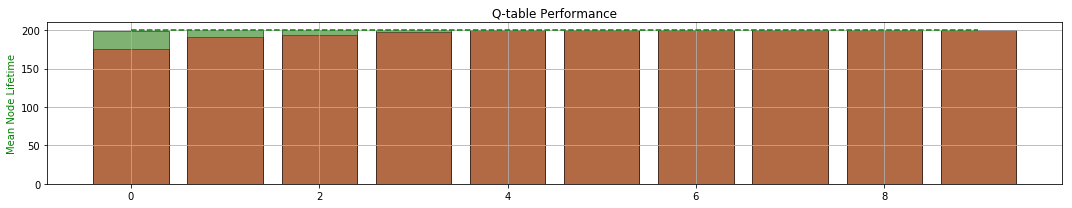

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6611
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  199.35
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:47.952155


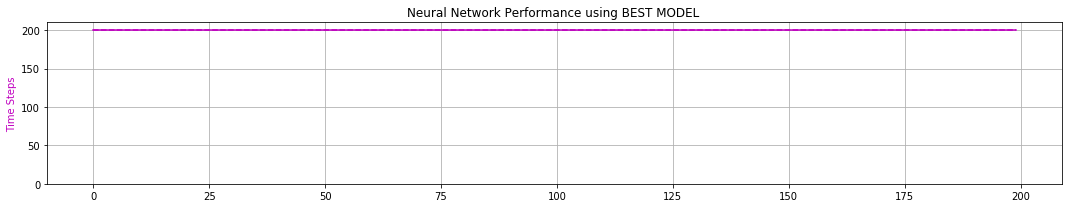

0 -max- [ 0.119  0.815  0.069  1.279  0.550]
0 -min- [-2.397 -1.861 -0.166 -1.150  0.375]

1 -max- [ 0.103  0.631  0.077  1.402  0.600]
1 -min- [-2.398 -1.881 -0.159 -1.174  0.400]

2 -max- [ 0.121  0.798  0.111  1.354  0.649]
2 -min- [-2.396 -1.792 -0.173 -1.141  0.451]

3 -max- [ 0.124  0.632  0.062  1.324  0.700]
3 -min- [-2.390 -1.787 -0.168 -0.984  0.500]

4 -max- [ 0.113  0.761  0.080  1.348  0.750]
4 -min- [-1.925 -1.509 -0.118 -1.126  0.550]

5 -max- [ 0.129  0.808  0.103  1.403  0.800]
5 -min- [-1.767 -1.696 -0.143 -1.315  0.601]

6 -max- [ 0.130  0.813  0.085  1.316  0.850]
6 -min- [-1.715 -1.370 -0.128 -1.080  0.650]

7 -max- [ 0.124  0.629  0.067  1.282  0.900]
7 -min- [-1.085 -1.168 -0.077 -1.220  0.700]

8 -max- [ 0.171  0.620  0.075  1.426  0.925]
8 -min- [-0.928 -1.354 -0.091 -0.974  0.751]

9 -max- [ 0.124  0.624  0.070  1.192  0.925]
9 -min- [-0.774 -1.161 -0.067 -1.073  0.800]



ITERATION # 11
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

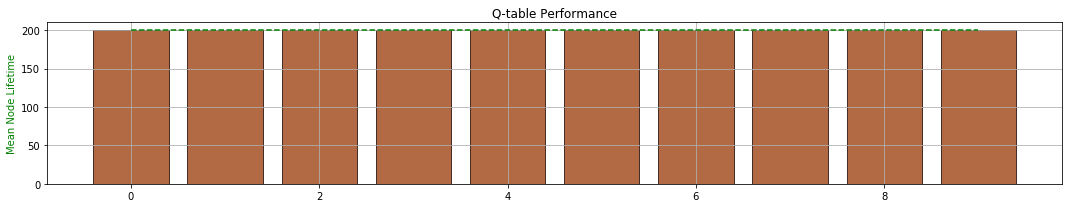

Problem SOLVED in iteration# 11


In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

#         node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
#                                             [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
#                                             [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################

#         # GET Q-VALUES 
#         %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#         # SAVE QFILE
#         node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#         np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
#     print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2323.0
Total Serial Timesteps   :  1774635.0
Speed-up                 :  763.94


In [21]:
pool.close()
pool.join()